In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [65]:
df = pd.read_csv('quntity_sum_sorted_by_date_complete.csv')

In [66]:
# unique_dates = df[[
#     'transaction_date']].drop_duplicates().values
# # Split the dates into 80:20 train and test sets


In [258]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
# from torch.utils.data.dataset import random_split
from sklearn.model_selection import train_test_split

In [259]:
class SalesDataset(Dataset):
    def __init__(self, df, unique_dates=None, days_per_batch=None):
        self.df = df.sort_values('transaction_date')
        self.unique_dates = df['transaction_date'].unique() if unique_dates is None else unique_dates        
        self.days_per_batch = len(
            self.unique_dates) - 1 if days_per_batch is None else days_per_batch
        self.num_records_per_day = len(
            df[df['transaction_date'] == self.unique_dates[0]])
        print("Unique days", len(self.unique_dates))
        print("No. recs per day", self.num_records_per_day)

        # Create a tensor to hold all the data
        self.data_tensor = torch.zeros(
            (len(self.unique_dates), self.num_records_per_day, 4), dtype=torch.float)
        self.target_tensor = torch.zeros(
            (len(self.unique_dates), self.num_records_per_day), dtype=torch.float)

        for i, date in enumerate(self.unique_dates[:-1]):
            current_data = self.df[self.df['transaction_date'] == date]
            data = current_data[['store_id', 'product_id',
                                 'transaction_qty', 'day_of_week']].values
            # Get next day's data
            next_date = self.unique_dates[i + 1]
            next_data = self.df[self.df['transaction_date'] == next_date]
            target = next_data['transaction_qty'].values

            self.data_tensor[i] = torch.tensor(data, dtype=torch.float)
            self.target_tensor[i] = torch.tensor(target, dtype=torch.float)

    def __len__(self):
        # Adjusted to return sequences of 14 days
        return len(self.unique_dates) - self.days_per_batch

    def __getitem__(self, idx):
        # Just index into the precomputed tensors
        sequence_data = self.data_tensor[idx :idx+self.days_per_batch]
        # targets are the next day's transaction quantities
        sequence_target = self.target_tensor[idx + 1: idx+self.days_per_batch+1]

        return sequence_data, sequence_target

In [260]:
# Split the unique dates into training and test sets
unique_dates = df['transaction_date'].unique()
train_dates, test_dates = train_test_split(
    unique_dates, test_size=0.2, shuffle=False)

days_per_batch = None
# Create the training and test datasets
train_dataset = SalesDataset(df, train_dates, days_per_batch)
test_dataset = SalesDataset(df, test_dates, days_per_batch)
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

Unique days 121
No. recs per day 261
Unique days 31
No. recs per day 261


In [272]:
dataset = SalesDataset(df)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

Unique days 152
No. recs per day 261


In [261]:
print(len(train_dates))
print(len(test_dates))
print(len(train_dataloader))
print(len(test_dataloader))
print(len(train_dates[0]))

121
31
1
1
10


In [262]:
data_iter = iter(train_dataloader)
print(data_iter)
batch1 = next(data_iter)
print("length: ", len(batch1))
print("data length: ", len(batch1[0]))
print("target length: ", len(batch1[1]))
print("data: ", batch1[0][0].shape)
print("target: ", batch1[1][0].shape)

length:  2
data length:  1
target length:  1
data:  torch.Size([120, 261, 4])
target:  torch.Size([120, 261])


In [263]:
# # Define the LSTM model
# class LSTM(nn.Module):
#     def __init__(self, input_size=4, hidden_layer_size=50, output_size=1):
#         super().__init__()
#         self.hidden_layer_size = hidden_layer_size
#         self.lstm = nn.LSTM(input_size, hidden_layer_size)
#         self.linear = nn.Linear(hidden_layer_size, output_size)
#         self.hidden_cell = (torch.zeros(1, 1, self.hidden_layer_size),
#                             torch.zeros(1, 1, self.hidden_layer_size))

#     def forward(self, input_seq):
#         lstm_out, self.hidden_cell = self.lstm(
#             input_seq.view(len(input_seq), 1, -1), self.hidden_cell)
#         predictions = self.linear(lstm_out.view(len(input_seq), -1))
#         return predictions

In [264]:
class LSTM(nn.Module):
    def __init__(self, input_size=261*4, hidden_layer_size=50, output_size=261, num_layers=2, dropout=0.5):
        super(LSTM, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_layer_size,
                            num_layers=num_layers, dropout=dropout, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, input_seq):
        # Flatten the last two dimensions of the input
        input_seq = input_seq.view(input_seq.shape[0], input_seq.shape[1], -1)

        h0 = torch.zeros(self.num_layers, input_seq.size(
            0), self.hidden_layer_size).to(input_seq.device)
        c0 = torch.zeros(self.num_layers, input_seq.size(
            0), self.hidden_layer_size).to(input_seq.device)

        lstm_out, _ = self.lstm(input_seq, (h0, c0))
        lstm_out = self.dropout(lstm_out)
        predictions = self.linear(lstm_out)
        return predictions

In [265]:
def train_model(model, criterion, optimizer, dataloader):
    model.train()
    total_loss = 0

    for data, target in dataloader:
        optimizer.zero_grad()
        output = model(data)
        # print(output.shape)
        # print(target.shape)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

In [266]:
def evaluate_model(model, criterion, dataloader):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for data, target in dataloader:
            output = model(data)
            # print(output.shape)
            # print(target.shape)
            loss = criterion(output, target)
            total_loss += loss.item()

    return total_loss / len(dataloader)

In [267]:
def model_fit(model, criterion, optimizer, train_dataloader, test_dataloader, num_epochs=25):
    train_losses = []
    test_losses = []

    for epoch in range(num_epochs):
        train_loss = train_model(model, criterion, optimizer, train_dataloader)
        test_loss = evaluate_model(model, criterion, test_dataloader)

        train_losses.append(train_loss)
        test_losses.append(test_loss)

        print(f'Epoch: {epoch+1}/{num_epochs}.. Training Loss: {train_loss}.. Test Loss: {test_loss}')

    return model, train_losses, test_losses

In [268]:
# # Initialize the model, loss function and optimizer
model = LSTM(hidden_layer_size=64, num_layers=4)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Epoch: 1/150.. Training Loss: 29.25339698791504.. Test Loss: 67.8114013671875
Epoch: 2/150.. Training Loss: 29.21027183532715.. Test Loss: 67.74314880371094
Epoch: 3/150.. Training Loss: 29.164609909057617.. Test Loss: 67.67105865478516
Epoch: 4/150.. Training Loss: 29.11538314819336.. Test Loss: 67.58839416503906
Epoch: 5/150.. Training Loss: 29.0640926361084.. Test Loss: 67.48582458496094
Epoch: 6/150.. Training Loss: 29.005613327026367.. Test Loss: 67.35450744628906
Epoch: 7/150.. Training Loss: 28.91029167175293.. Test Loss: 67.1812744140625
Epoch: 8/150.. Training Loss: 28.808521270751953.. Test Loss: 66.95018768310547
Epoch: 9/150.. Training Loss: 28.659324645996094.. Test Loss: 66.64513397216797
Epoch: 10/150.. Training Loss: 28.462221145629883.. Test Loss: 66.24954223632812
Epoch: 11/150.. Training Loss: 28.199689865112305.. Test Loss: 65.7577133178711
Epoch: 12/150.. Training Loss: 27.90619468688965.. Test Loss: 65.1757583618164
Epoch: 13/150.. Training Loss: 27.60411071777343

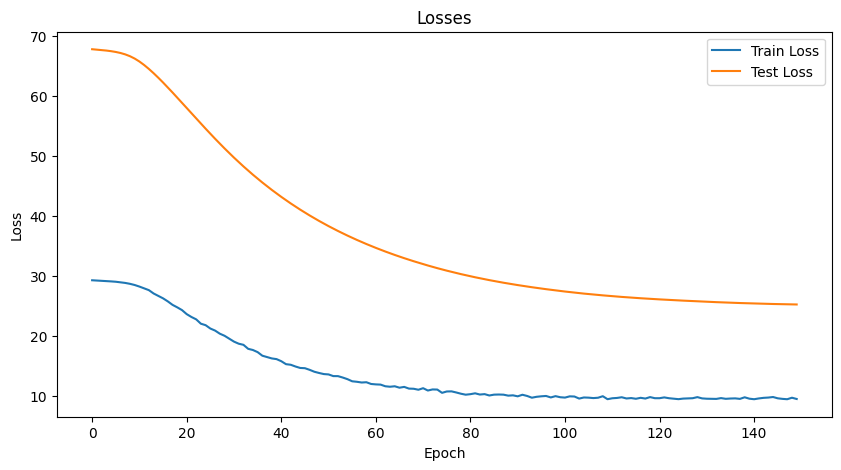

In [269]:
# Run model_fit
model, train_losses, test_losses = model_fit(
    model, loss_function, optimizer, train_dataloader, test_dataloader, 150)

# Plot the losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [342]:
train_dates, test_dates = train_test_split(
    unique_dates, test_size=0.2, shuffle=False)

days_per_batch = None
# Create the training and test datasets
train_dataset = SalesDataset(df, unique_dates, days_per_batch)
test_dataset = SalesDataset(df, test_dates, days_per_batch)
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

Unique days 152
No. recs per day 261
Unique days 31
No. recs per day 261


In [343]:
# # Initialize the model, loss function and optimizer
model = LSTM(hidden_layer_size=64, num_layers=4)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

Epoch: 1/200.. Training Loss: 37.50051498413086.. Test Loss: 67.60154724121094
Epoch: 2/200.. Training Loss: 37.44804763793945.. Test Loss: 67.52516174316406
Epoch: 3/200.. Training Loss: 37.39056396484375.. Test Loss: 67.4401626586914
Epoch: 4/200.. Training Loss: 37.32392501831055.. Test Loss: 67.33967590332031
Epoch: 5/200.. Training Loss: 37.244327545166016.. Test Loss: 67.22014617919922
Epoch: 6/200.. Training Loss: 37.17693328857422.. Test Loss: 67.07231140136719
Epoch: 7/200.. Training Loss: 37.06911087036133.. Test Loss: 66.88404846191406
Epoch: 8/200.. Training Loss: 36.92339324951172.. Test Loss: 66.64271545410156
Epoch: 9/200.. Training Loss: 36.72916793823242.. Test Loss: 66.32727813720703
Epoch: 10/200.. Training Loss: 36.500099182128906.. Test Loss: 65.91763305664062
Epoch: 11/200.. Training Loss: 36.19110107421875.. Test Loss: 65.37786102294922
Epoch: 12/200.. Training Loss: 35.850284576416016.. Test Loss: 64.73673248291016
Epoch: 13/200.. Training Loss: 35.27978515625..

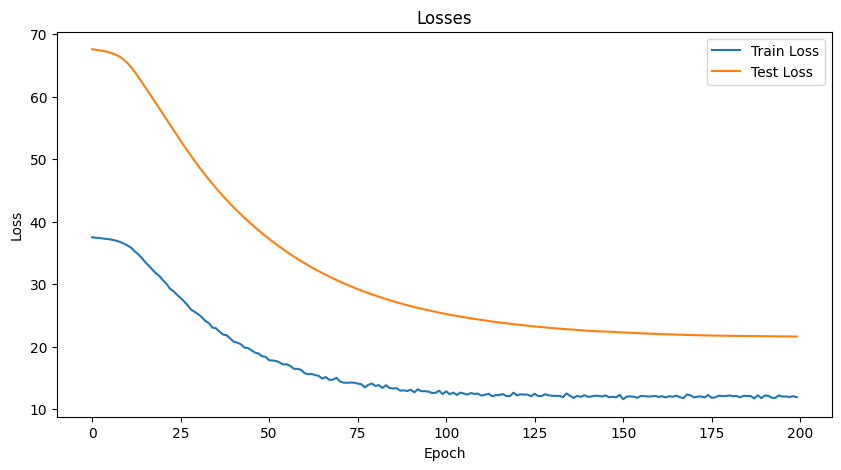

In [344]:
# Run model_fit
model, train_losses, test_losses = model_fit(
    model, loss_function, optimizer, train_dataloader, test_dataloader, 200)

# Plot the losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [345]:
from datetime import datetime, timedelta

# Assuming model is your trained model
# The model is used to predict the transaction_qty for each day
df = pd.read_csv('quntity_sum_sorted_by_date_complete.csv')

# Initialize store_id, product_id and transaction_date
store_id = 1
product_id = 1
transaction_date = datetime.strptime('2024-06-01', '%Y-%m-%d')

# Create 261 new entries for each day, for 14 days
for day in range(14):
    print("Day: ", day)
    # Generate 261 predictions for the day
    dataset = SalesDataset(df)
    dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
    data_iter = iter(dataloader)
    data, target = next(data_iter)
    predictions = model(data)
    # print(predictions[0, -1, 0].item())
    # print(predictions.shape)
    for i in range(261):
        # Append a new entry to the DataFrame
        new_entry = pd.DataFrame({
            'transaction_date': [transaction_date],  # Removed pd.to_datetime()
            'store_id': [store_id],
            'product_id': [product_id],
            'transaction_qty': [np.round(predictions[0, -1, i].item())],
            'day_of_week': [transaction_date.weekday()]
        })
        # print(new_entry)
        df = pd.concat([df, new_entry], ignore_index=True)
        df['transaction_date'] = pd.to_datetime(df['transaction_date'])
        
        # Update product_id and store_id for the next entry
        product_id += 1
        if product_id > 87:
            product_id = 1
            store_id += 1
        if store_id > 3:
            store_id = 1

    # Update transaction_date for the next day
    transaction_date += timedelta(days=1)

# At the end of the loop, new_entries contains 261 new entries for each day, for 14 days

Day:  0
Unique days 152
No. recs per day 261
Day:  1
Unique days 153
No. recs per day 261
Day:  2
Unique days 154
No. recs per day 261
Day:  3
Unique days 155
No. recs per day 261
Day:  4
Unique days 156
No. recs per day 261
Day:  5
Unique days 157
No. recs per day 261
Day:  6
Unique days 158
No. recs per day 261
Day:  7
Unique days 159
No. recs per day 261
Day:  8
Unique days 160
No. recs per day 261
Day:  9
Unique days 161
No. recs per day 261
Day:  10
Unique days 162
No. recs per day 261
Day:  11
Unique days 163
No. recs per day 261
Day:  12
Unique days 164
No. recs per day 261
Day:  13
Unique days 165
No. recs per day 261


In [294]:
# df.to_csv('output.csv', index=False)

In [351]:
df.tail(261*14).to_csv('my_submission.csv', index=False)

In [347]:
df_filtered = df.drop(columns=['day_of_week'])
# df_filtered.tail(261*14).to_csv('my_submission_final.csv')

In [350]:
df.tail

<bound method NDFrame.tail of       transaction_date  store_id  product_id  transaction_qty  day_of_week
0           2024-01-01         1           1              0.0            0
1           2024-01-01         1           2              0.0            0
2           2024-01-01         1           3              0.0            0
3           2024-01-01         1           4              0.0            0
4           2024-01-01         1           5              0.0            0
...                ...       ...         ...              ...          ...
43321       2024-06-14         3          83             -0.0            4
43322       2024-06-14         3          84             -0.0            4
43323       2024-06-14         3          85              2.0            4
43324       2024-06-14         3          86              2.0            4
43325       2024-06-14         3          87              0.0            4

[43326 rows x 5 columns]>

In [305]:
submission = pd.read_csv('submission_key.csv')
df_filtered['transaction_date'] = df_filtered['transaction_date'].dt.strftime(
    '%Y-%m-%d')
df_filtered['store_id'] = 'ST' + df_filtered['store_id'].astype(str)
# Merge df_filtered and submission on all columns
df_filtered = df_filtered.merge(submission, how='inner')

In [310]:
# df_filtered = df_filtered[['ID', 'transaction_date',
#                            'store_id', 'product_id', 'transaction_qty']]

In [311]:
df_final = df_filtered[['ID', 'transaction_qty']].rename(
    columns={'transaction_qty': 'sold_qty'})
df_final.to_csv('my_submission_final.csv', index=False)